In [47]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from d2l import torch as d2l
import matplotlib.pyplot as plt

# 5. 深度学习计算

## 课后习题

### 5.1 层和块

1. 如果将MySequential中存储块的方式更改为Python列表，会出现什么样的问题？

    使用`list`存储块，无法打印出模型结构和参数

In [36]:
class MySequential2(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.my_modules = []
        for _, module in enumerate(args):
            self.my_modules.append(module)

    def forward(self, X):
        for block in self.my_modules:
            X = block(X)
        return X

net = MySequential2(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X), net, net.state_dict()

(tensor([[ 0.1104, -0.1127,  0.2166,  0.3063, -0.2770, -0.1436,  0.1244, -0.0439,
           0.1986, -0.1751],
         [ 0.0417, -0.0202,  0.2739,  0.1633, -0.2561, -0.0262,  0.1424,  0.0077,
           0.1492, -0.0519]], grad_fn=<AddmmBackward0>),
 MySequential2(),
 OrderedDict())

2. 实现一个块，它以两个块为参数，例如net1和net2，并返回前向传播中两个网络的串联输出。这也被称为平行块。

In [38]:
class ParallelBlock(nn.Module):
    def __init__(self, net1, net2):
        super().__init__()
        self.net1 = net1
        self.net2 = net2
    
    def forward(self, X):
        return self.net2(self.net1(X))
    
net = ParallelBlock(nn.Linear(20, 256), nn.Linear(256, 10))
net(X), net

(tensor([[-0.2180,  0.1762,  0.1760,  0.1883,  0.1553,  0.0703, -0.1332, -0.3720,
           0.6114,  0.4129],
         [-0.2588,  0.2947, -0.0048,  0.2907,  0.2431, -0.0085, -0.1624, -0.3391,
           0.6342,  0.0845]], grad_fn=<AddmmBackward0>),
 ParallelBlock(
   (net1): Linear(in_features=20, out_features=256, bias=True)
   (net2): Linear(in_features=256, out_features=10, bias=True)
 ))

3. 假设我们想要连接同一网络的多个实例。实现一个函数，该函数生成同一个块的多个实例，并在此基础上构建更大的网络。

In [43]:
class MyNet(nn.Module):
    """
    定义网络
    """
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    
    def forward(self, X):
        return F.relu(self.linear(X))
    
def create_network(num_inputs, num_outputs, n):
    prev = num_inputs
    net = nn.Sequential()
    for i in range(1, n):
        out = np.random.randint(prev // 2, prev * 2)
        net.add_module(str(i), MyNet(prev, out))
        prev = out
    net.add_module(str(n), MyNet(prev, num_outputs))
    return net

net = create_network(20, 10, 5)
net(X), net

(tensor([[0.3020, 0.1500, 0.0905, 0.2358, 0.0000, 0.0000, 0.0767, 0.0000, 0.0000,
          0.0000],
         [0.2932, 0.1482, 0.0855, 0.2313, 0.0000, 0.0000, 0.0820, 0.0000, 0.0000,
          0.0000]], grad_fn=<ReluBackward0>),
 Sequential(
   (1): MyNet(
     (linear): Linear(in_features=20, out_features=10, bias=True)
   )
   (2): MyNet(
     (linear): Linear(in_features=10, out_features=9, bias=True)
   )
   (3): MyNet(
     (linear): Linear(in_features=9, out_features=6, bias=True)
   )
   (4): MyNet(
     (linear): Linear(in_features=6, out_features=11, bias=True)
   )
   (5): MyNet(
     (linear): Linear(in_features=11, out_features=10, bias=True)
   )
 ))

## 5.2 参数管理

1. 访问`NestMLP`各个层的参数。

In [57]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

net = NestMLP()
print(net)
print("=" * 32)
# 方法1
for i in net.named_parameters():
    print("shape of", i[0], "is ", i[1].shape)
print("=" * 32)

# 方法二
for k, v in net.state_dict().items():
    print("shape of", k, "is ", v.shape)

NestMLP(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (linear): Linear(in_features=32, out_features=16, bias=True)
)
shape of net.0.weight is  torch.Size([64, 20])
shape of net.0.bias is  torch.Size([64])
shape of net.2.weight is  torch.Size([32, 64])
shape of net.2.bias is  torch.Size([32])
shape of linear.weight is  torch.Size([16, 32])
shape of linear.bias is  torch.Size([16])
shape of net.0.weight is  torch.Size([64, 20])
shape of net.0.bias is  torch.Size([64])
shape of net.2.weight is  torch.Size([32, 64])
shape of net.2.bias is  torch.Size([32])
shape of linear.weight is  torch.Size([16, 32])
shape of linear.bias is  torch.Size([16])


3. 构建包含共享参数层的多层感知机并对其进行训练。在训练过程中，观察模型各层的参数和梯度。

    如下，每一层只看一个隐藏单元某个权重的参数和其梯度，可以看到共享层的梯度和参数全是一样的。

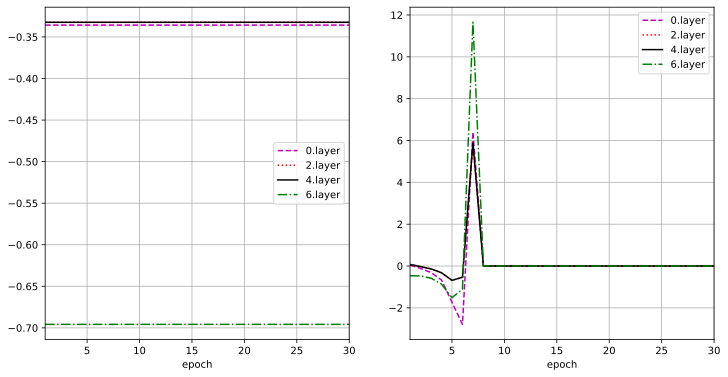

In [79]:
shared = nn.Linear(4, 4, bias=False)
net = nn.Sequential(nn.Linear(2, 4, bias=False), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(4, 1, bias=False))
true_w = torch.tensor([4.2, -2.3])
true_b = 0 
X, y = d2l.synthetic_data(true_w, true_b, 100)

def train():
    net.train()
    loss = nn.MSELoss()
    num_epochs = 30
    updater = torch.optim.SGD(net.parameters(), lr=0.1)
    fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    fmts = ['m--', 'r:', 'k-', 'g-.']
    animator_param = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], fig=fig, 
                                  legend=("0.layer", "2.layer", "4.layer", "6.layer"),
                                  fmts=fmts)
    animator_grad = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], fig=fig, 
                                 legend=("0.layer", "2.layer", "4.layer", "6.layer"),
                                 fmts=fmts)
    animator_param.axes = [axes[0]]
    animator_grad.axes = [axes[1]]
    axes[0].set_title("parameter"), axes[1].set_title("gradient")
    for epoch in range(num_epochs):
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.backward()
        updater.step()
        weights, grads = [], []
        for sub in net:
            if not isinstance(sub, nn.Linear):
                continue
            weights.append(sub.weight.data[0][0])
            grads.append(sub.weight.grad[0][0])
        animator_param.add(epoch+1, weights)
        animator_grad.add(epoch+1, grads)

train()

## 5.4 自定义层

1. 设计一个接受输入并计算张量降维的层，它返回$y_k=\sum_{i, j}W_{ijk}x_ix_j$

In [81]:
class MyLayer(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.weight = nn.Parameter(torch.randn((num_outputs, num_inputs, num_inputs)))
    
    def forward(self, X):
        return (X @ self.weight @ X.T).reshape(-1, 1)
    
net = MyLayer(10, 5)
X = torch.randn((1, 10))
net(X)

tensor([[-19.7216],
        [-20.0911],
        [ 12.7527],
        [  4.7720],
        [  6.4139]], grad_fn=<ViewBackward0>)